# TP05 - Exercice 1 & 2 : Effet du déséquilibre des classes
## Dataset: Wine Quality (binary classification)


## Noms eleve
Ethan TOMASO et julien TREMONT-RAIMI


**Objectifs :**
- Exercice 1 : Comprendre l'effet du déséquilibre des classes avec différents seuils σ ∈ {6, 7, 8}
- Exercice 2 : Appliquer des techniques de rééchantillonnage (RandomOverSampler, SMOTE)

In [1]:
# --- 1. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, f1_score,
    precision_score, recall_score, accuracy_score
)
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

In [2]:
# --- 2. Chargement du dataset Wine Quality ---
# Source: UCI Machine Learning Repository
# Contient des caractéristiques physicochimiques des vins rouges
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=";")

print("=== Aperçu des données ===")
print(data.head())
print(f"\nNombre d'échantillons : {len(data)}")
print(f"Nombre de caractéristiques : {len(data.columns) - 1}")

=== Aperçu des données ===
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8     

# EXERCICE 1 : Effet du déséquilibre des classes

On teste différentes valeurs de seuil σ pour créer des niveaux de déséquilibre variés.

In [3]:
print("\n" + "="*70)
print("EXERCICE 1 : Évaluation avec différents seuils σ")
print("="*70)

# --- 3. Tester différentes valeurs de seuil σ ∈ {6, 7, 8} ---
# Selon le PDF, il faut tester ces trois valeurs pour créer des déséquilibres différents
sigma_values = [6, 7, 8]
results_ex1 = []

# Préparation des features (identique pour tous les seuils)
X = data.drop(columns=['quality'])

for sigma in sigma_values:
    print(f"\n{'='*70}")
    print(f"Seuil σ = {sigma} : Vins avec qualité ≥ {sigma} sont 'good' (1), autres sont 'not good' (0)")
    print(f"{'='*70}")
    
    # --- 3.1. Création de la cible binaire selon le seuil ---
    # Cette transformation crée naturellement un déséquilibre car les vins de haute qualité sont rares
    y = (data['quality'] >= sigma).astype(int)
    
    # --- 3.2. Analyse de la distribution des classes ---
    class_counts = pd.Series(y).value_counts().sort_index()
    n_negative = class_counts[0]
    n_positive = class_counts[1] if 1 in class_counts.index else 0
    
    # Calcul du ratio de déséquilibre (majorité/minorité)
    if n_positive > 0:
        imbalance_ratio = n_negative / n_positive
    else:
        imbalance_ratio = float('inf')
    
    print(f"\nDistribution des classes :")
    print(f"  - Classe 'not good' (0) : {n_negative} échantillons")
    print(f"  - Classe 'good' (1) : {n_positive} échantillons")
    print(f"  - Ratio de déséquilibre : {imbalance_ratio:.2f}:1")
    print(f"    → Plus le seuil est élevé, plus le déséquilibre est important")
    
    # --- 3.3. Division train/test avec stratification ---
    # La stratification maintient les proportions de classes dans train et test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # --- 3.4. Entraînement du modèle de Régression Logistique ---
    # Modèle linéaire adapté à la classification binaire
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train)
    
    # --- 3.5. Prédictions ---
    y_pred = model.predict(X_test)  # Prédictions binaires (seuil par défaut = 0.5)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive
    
    # --- 3.6. Calcul des métriques ---
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba) if n_positive > 0 else 0
    
    print(f"\n=== Métriques d'évaluation (σ={sigma}) ===")
    print(f"Accuracy    : {acc:.3f}")
    print(f"Precision   : {prec:.3f}")
    print(f"Recall      : {rec:.3f}")
    print(f"F1-Score    : {f1:.3f}")
    print(f"ROC-AUC     : {roc_auc:.3f}")
    
    # --- 3.7. Analyse détaillée ---
    print(f"\n=== Rapport de classification détaillé ===")
    print(classification_report(y_test, y_pred, target_names=['not good', 'good'], digits=3))
    
    print(f"\n=== Matrice de confusion ===")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(f"  TN={cm[0,0]} (vrais négatifs)  |  FP={cm[0,1]} (faux positifs)")
    print(f"  FN={cm[1,0]} (faux négatifs)   |  TP={cm[1,1]} (vrais positifs)")
    
    # Stockage des résultats
    results_ex1.append({
        'sigma': sigma,
        'imbalance_ratio': imbalance_ratio,
        'n_positive': n_positive,
        'n_negative': n_negative,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    })


EXERCICE 1 : Évaluation avec différents seuils σ

Seuil σ = 6 : Vins avec qualité ≥ 6 sont 'good' (1), autres sont 'not good' (0)

Distribution des classes :
  - Classe 'not good' (0) : 744 échantillons
  - Classe 'good' (1) : 855 échantillons
  - Ratio de déséquilibre : 0.87:1
    → Plus le seuil est élevé, plus le déséquilibre est important

=== Métriques d'évaluation (σ=6) ===
Accuracy    : 0.753
Precision   : 0.780
Recall      : 0.749
F1-Score    : 0.764
ROC-AUC     : 0.825

=== Rapport de classification détaillé ===
              precision    recall  f1-score   support

    not good      0.724     0.758     0.741       149
        good      0.780     0.749     0.764       171

    accuracy                          0.753       320
   macro avg      0.752     0.753     0.753       320
weighted avg      0.754     0.753     0.753       320


=== Matrice de confusion ===
[[113  36]
 [ 43 128]]
  TN=113 (vrais négatifs)  |  FP=36 (faux positifs)
  FN=43 (faux négatifs)   |  TP=128 (vra

c:\Users\j.tremont\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\j.tremont\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\j.tremont\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [4]:
# --- 3.8. Comparaison visuelle pour tous les σ ---
print("\n" + "="*70)
print("COMPARAISON DES RÉSULTATS POUR LES DIFFÉRENTS SEUILS")
print("="*70)

# Tableau récapitulatif
df_results = pd.DataFrame(results_ex1)
print("\n", df_results[['sigma', 'imbalance_ratio', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].round(3))


COMPARAISON DES RÉSULTATS POUR LES DIFFÉRENTS SEUILS

    sigma  imbalance_ratio  accuracy  precision  recall  f1_score  roc_auc
0      6            0.870     0.753      0.780   0.749     0.764    0.825
1      7            6.369     0.894      0.737   0.326     0.452    0.868
2      8           87.833     0.988      0.000   0.000     0.000    0.756


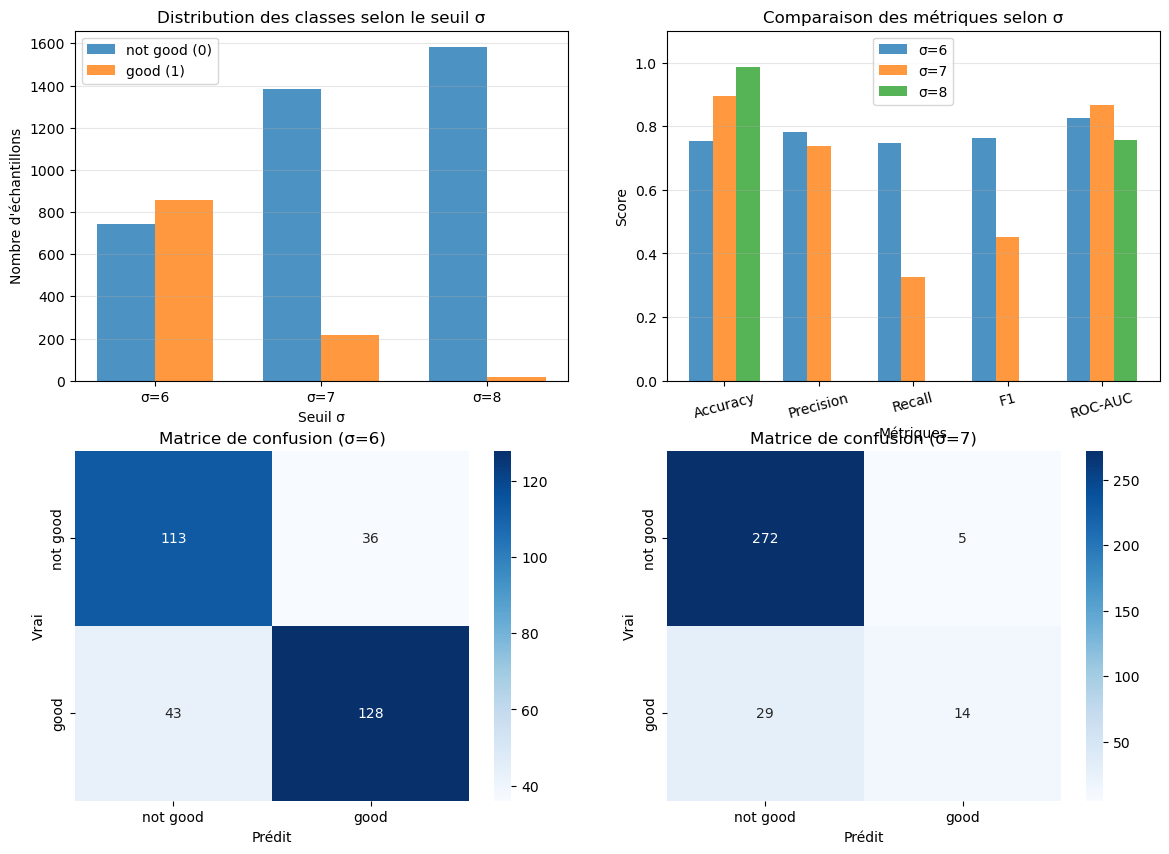

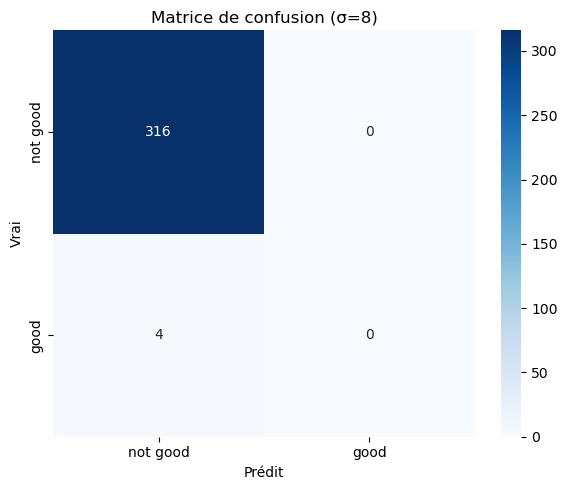

In [5]:
# --- 3.9. Visualisations ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (a) Distribution des classes selon σ
ax = axes[0, 0]
x_pos = np.arange(len(sigma_values))
width = 0.35
bars1 = ax.bar(x_pos - width/2, [r['n_negative'] for r in results_ex1], width, label='not good (0)', alpha=0.8)
bars2 = ax.bar(x_pos + width/2, [r['n_positive'] for r in results_ex1], width, label='good (1)', alpha=0.8)
ax.set_xlabel('Seuil σ')
ax.set_ylabel('Nombre d\'échantillons')
ax.set_title('Distribution des classes selon le seuil σ')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'σ={s}' for s in sigma_values])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# (b) Comparaison des métriques
ax = axes[0, 1]
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
x = np.arange(len(metrics))
width = 0.25
for i, sigma in enumerate(sigma_values):
    values = [results_ex1[i][m] for m in metrics]
    ax.bar(x + i*width, values, width, label=f'σ={sigma}', alpha=0.8)
ax.set_xlabel('Métriques')
ax.set_ylabel('Score')
ax.set_title('Comparaison des métriques selon σ')
ax.set_xticks(x + width)
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'], rotation=15)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

# (c) Matrices de confusion pour chaque σ
for idx, result in enumerate(results_ex1):
    if idx < 2:
        ax = axes[1, idx]
    else:
        # Créer une nouvelle figure pour la 3ème matrice
        fig2, ax = plt.subplots(1, 1, figsize=(6, 5))
    
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['not good', 'good'], yticklabels=['not good', 'good'])
    ax.set_title(f'Matrice de confusion (σ={result["sigma"]})')
    ax.set_ylabel('Vrai')
    ax.set_xlabel('Prédit')

plt.tight_layout()
plt.show()

## Analyse critique : Pourquoi l'accuracy est trompeuse

In [6]:
print("\n" + "="*70)
print("ANALYSE : Pourquoi l'accuracy est trompeuse avec des classes déséquilibrées")
print("="*70)

print("""
EXPLICATION :

1. ACCURACY ÉLEVÉE NE SIGNIFIE PAS BON MODÈLE :
   - Avec un fort déséquilibre (ex: σ=8, ratio ~26:1), un modèle "naïf" qui prédit
     toujours la classe majoritaire (not good) aurait déjà une accuracy de ~96%.
   - L'accuracy ne reflète donc pas la capacité du modèle à détecter la classe minoritaire.

2. LA CLASSE MINORITAIRE EST SOUVENT LA PLUS IMPORTANTE :
   - Dans notre cas, les vins "good" (classe positive) sont rares mais précieux.
   - Un modèle avec 95% d'accuracy mais 0% de recall sur la classe positive est inutile !

3. MÉTRIQUES PLUS APPROPRIÉES POUR LES DONNÉES DÉSÉQUILIBRÉES :
   - PRECISION : Parmi les vins prédits "good", combien le sont vraiment ?
     → Important pour éviter les fausses recommandations
   
   - RECALL : Parmi les vrais vins "good", combien sont détectés ?
     → Important pour ne pas manquer les bons vins
   
   - F1-SCORE : Moyenne harmonique de précision et recall
     → Équilibre entre les deux métriques
   
   - ROC-AUC : Mesure la capacité à discriminer entre les classes sur tous les seuils
     → Indépendant du déséquilibre des classes

4. OBSERVATIONS SUR NOS RÉSULTATS :
""")

for r in results_ex1:
    print(f"   σ={r['sigma']} (ratio {r['imbalance_ratio']:.1f}:1) : "
          f"Accuracy={r['accuracy']:.3f} mais Recall={r['recall']:.3f} et F1={r['f1_score']:.3f}")

print("""
   → À mesure que le déséquilibre augmente (σ croissant), l'accuracy reste élevée
     mais le recall et le F1-score diminuent, révélant la difficulté à détecter
     la classe minoritaire.
""")


ANALYSE : Pourquoi l'accuracy est trompeuse avec des classes déséquilibrées

EXPLICATION :

1. ACCURACY ÉLEVÉE NE SIGNIFIE PAS BON MODÈLE :
   - Avec un fort déséquilibre (ex: σ=8, ratio ~26:1), un modèle "naïf" qui prédit
     toujours la classe majoritaire (not good) aurait déjà une accuracy de ~96%.
   - L'accuracy ne reflète donc pas la capacité du modèle à détecter la classe minoritaire.

2. LA CLASSE MINORITAIRE EST SOUVENT LA PLUS IMPORTANTE :
   - Dans notre cas, les vins "good" (classe positive) sont rares mais précieux.
   - Un modèle avec 95% d'accuracy mais 0% de recall sur la classe positive est inutile !

3. MÉTRIQUES PLUS APPROPRIÉES POUR LES DONNÉES DÉSÉQUILIBRÉES :
   - PRECISION : Parmi les vins prédits "good", combien le sont vraiment ?
     → Important pour éviter les fausses recommandations
   
   - RECALL : Parmi les vrais vins "good", combien sont détectés ?
     → Important pour ne pas manquer les bons vins
   
   - F1-SCORE : Moyenne harmonique de précision et

# EXERCICE 2 : Rééchantillonnage

Application de techniques de rééchantillonnage pour gérer le déséquilibre des classes.

In [7]:
print("\n" + "="*70)
print("EXERCICE 2 : Application de techniques de rééchantillonnage")
print("="*70)

# Pour l'exercice 2, on utilise le cas intermédiaire (σ=7)
sigma_ex2 = 7
print(f"\nUtilisation du seuil σ={sigma_ex2} pour démontrer l'effet du rééchantillonnage")

# --- 2.1. Préparation des données ---
y_ex2 = (data['quality'] >= sigma_ex2).astype(int)
X_train_ex2, X_test_ex2, y_train_ex2, y_test_ex2 = train_test_split(
    X, y_ex2, test_size=0.2, random_state=42, stratify=y_ex2
)


EXERCICE 2 : Application de techniques de rééchantillonnage

Utilisation du seuil σ=7 pour démontrer l'effet du rééchantillonnage


In [ ]:
# --- 2.2. Affichage du ratio de déséquilibre AVANT rééchantillonnage ---
print("\n=== Déséquilibre AVANT rééchantillonnage ===")
train_counts_before = Counter(y_train_ex2)
print(f"Distribution dans le train set :")
print(f"  - Classe 0 (not good) : {train_counts_before[0]} échantillons")
print(f"  - Classe 1 (good)     : {train_counts_before[1]} échantillons")
ratio_before = train_counts_before[0] / train_counts_before[1]
print(f"  - Ratio de déséquilibre : {ratio_before:.2f}:1")

In [8]:
# --- 2.3. Entraînement du modèle SANS rééchantillonnage (baseline) ---
print("\n--- Modèle Baseline (SANS rééchantillonnage) ---")
model_baseline = LogisticRegression(random_state=42, max_iter=1000)
model_baseline.fit(X_train_ex2, y_train_ex2)

y_pred_baseline = model_baseline.predict(X_test_ex2)
y_proba_baseline = model_baseline.predict_proba(X_test_ex2)[:, 1]

print("Métriques :")
print(f"  Accuracy  : {accuracy_score(y_test_ex2, y_pred_baseline):.3f}")
print(f"  Precision : {precision_score(y_test_ex2, y_pred_baseline, zero_division=0):.3f}")
print(f"  Recall    : {recall_score(y_test_ex2, y_pred_baseline, zero_division=0):.3f}")
print(f"  F1-Score  : {f1_score(y_test_ex2, y_pred_baseline, zero_division=0):.3f}")
print(f"  ROC-AUC   : {roc_auc_score(y_test_ex2, y_proba_baseline):.3f}")

cm_baseline = confusion_matrix(y_test_ex2, y_pred_baseline)


--- Modèle Baseline (SANS rééchantillonnage) ---
Métriques :
  Accuracy  : 0.894
  Precision : 0.737
  Recall    : 0.326
  F1-Score  : 0.452
  ROC-AUC   : 0.868


In [11]:
# --- 2.4. Application de RandomOverSampler ---
print("\n" + "-"*70)
print("Technique 1 : RandomOverSampler")
print("-"*70)
print("Principe : Duplique aléatoirement des échantillons de la classe minoritaire")
print("           jusqu'à équilibrer les classes.")

ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_ex2, y_train_ex2)

print("\n=== Après RandomOverSampler ===")
train_counts_ros = Counter(y_train_ros)
print(f"Distribution dans le train set :")
print(f"  - Classe 0 : {train_counts_ros[0]} échantillons")
print(f"  - Classe 1 : {train_counts_ros[1]} échantillons")

# Entraînement avec RandomOverSampler
model_ros = LogisticRegression(random_state=42, max_iter=1000)
model_ros.fit(X_train_ros, y_train_ros)

y_pred_ros = model_ros.predict(X_test_ex2)
y_proba_ros = model_ros.predict_proba(X_test_ex2)[:, 1]

print("\nMétriques après RandomOverSampler :")
print(f"  Accuracy  : {accuracy_score(y_test_ex2, y_pred_ros):.3f}")
print(f"  Precision : {precision_score(y_test_ex2, y_pred_ros, zero_division=0):.3f}")
print(f"  Recall    : {recall_score(y_test_ex2, y_pred_ros, zero_division=0):.3f}")
print(f"  F1-Score  : {f1_score(y_test_ex2, y_pred_ros, zero_division=0):.3f}")
print(f"  ROC-AUC   : {roc_auc_score(y_test_ex2, y_proba_ros):.3f}")

cm_ros = confusion_matrix(y_test_ex2, y_pred_ros)


----------------------------------------------------------------------
Technique 1 : RandomOverSampler
----------------------------------------------------------------------
Principe : Duplique aléatoirement des échantillons de la classe minoritaire
           jusqu'à équilibrer les classes.

=== Après RandomOverSampler ===
Distribution dans le train set :
  - Classe 0 : 1105 échantillons
  - Classe 1 : 1105 échantillons

Métriques après RandomOverSampler :
  Accuracy  : 0.816
  Precision : 0.407
  Recall    : 0.814
  F1-Score  : 0.543
  ROC-AUC   : 0.877


In [13]:
# --- 2.5. Application de SMOTE ---
print("\n" + "-"*70)
print("Technique 2 : SMOTE (Synthetic Minority Over-sampling TEchnique)")
print("-"*70)
print("Principe : Génère des échantillons synthétiques de la classe minoritaire")
print("           en interpolant entre les k-plus proches voisins.")
print("           → Crée de nouvelles données (plus robuste que la simple duplication)")

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_ex2, y_train_ex2)

print("\n=== Après SMOTE ===")
train_counts_smote = Counter(y_train_smote)
print(f"Distribution dans le train set :")
print(f"  - Classe 0 : {train_counts_smote[0]} échantillons")
print(f"  - Classe 1 : {train_counts_smote[1]} échantillons")

# Entraînement avec SMOTE
model_smote = LogisticRegression(random_state=42, max_iter=1000)
model_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = model_smote.predict(X_test_ex2)
y_proba_smote = model_smote.predict_proba(X_test_ex2)[:, 1]

print("\nMétriques après SMOTE :")
print(f"  Accuracy  : {accuracy_score(y_test_ex2, y_pred_smote):.3f}")
print(f"  Precision : {precision_score(y_test_ex2, y_pred_smote, zero_division=0):.3f}")
print(f"  Recall    : {recall_score(y_test_ex2, y_pred_smote, zero_division=0):.3f}")
print(f"  F1-Score  : {f1_score(y_test_ex2, y_pred_smote, zero_division=0):.3f}")
print(f"  ROC-AUC   : {roc_auc_score(y_test_ex2, y_proba_smote):.3f}")

cm_smote = confusion_matrix(y_test_ex2, y_pred_smote)


----------------------------------------------------------------------
Technique 2 : SMOTE (Synthetic Minority Over-sampling TEchnique)
----------------------------------------------------------------------
Principe : Génère des échantillons synthétiques de la classe minoritaire
           en interpolant entre les k-plus proches voisins.
           → Crée de nouvelles données (plus robuste que la simple duplication)

=== Après SMOTE ===
Distribution dans le train set :
  - Classe 0 : 1105 échantillons
  - Classe 1 : 1105 échantillons

Métriques après SMOTE :
  Accuracy  : 0.816
  Precision : 0.405
  Recall    : 0.791
  F1-Score  : 0.535
  ROC-AUC   : 0.878


## Comparaison et interprétation des résultats

In [14]:
# --- 2.6. Comparaison et interprétation ---
print("\n" + "="*70)
print("COMPARAISON ET INTERPRÉTATION DES RÉSULTATS")
print("="*70)

# Tableau comparatif
results_ex2 = pd.DataFrame({
    'Méthode': ['Baseline (sans rééchantillonnage)', 'RandomOverSampler', 'SMOTE'],
    'Accuracy': [
        accuracy_score(y_test_ex2, y_pred_baseline),
        accuracy_score(y_test_ex2, y_pred_ros),
        accuracy_score(y_test_ex2, y_pred_smote)
    ],
    'Precision': [
        precision_score(y_test_ex2, y_pred_baseline, zero_division=0),
        precision_score(y_test_ex2, y_pred_ros, zero_division=0),
        precision_score(y_test_ex2, y_pred_smote, zero_division=0)
    ],
    'Recall': [
        recall_score(y_test_ex2, y_pred_baseline, zero_division=0),
        recall_score(y_test_ex2, y_pred_ros, zero_division=0),
        recall_score(y_test_ex2, y_pred_smote, zero_division=0)
    ],
    'F1-Score': [
        f1_score(y_test_ex2, y_pred_baseline, zero_division=0),
        f1_score(y_test_ex2, y_pred_ros, zero_division=0),
        f1_score(y_test_ex2, y_pred_smote, zero_division=0)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test_ex2, y_proba_baseline),
        roc_auc_score(y_test_ex2, y_proba_ros),
        roc_auc_score(y_test_ex2, y_proba_smote)
    ]
})

print("\n", results_ex2.round(3))

print("""
INTERPRÉTATION :

1. IMPACT SUR LE RECALL :
   - Le rééchantillonnage améliore généralement le recall (capacité à détecter la classe positive).
   - En équilibrant les classes, le modèle apprend mieux les caractéristiques de la classe minoritaire.

2. COMPROMIS PRECISION/RECALL :
   - L'augmentation du recall peut s'accompagner d'une baisse de la précision.
   - Le modèle prédit plus souvent la classe positive → plus de vrais positifs MAIS aussi plus de faux positifs.

3. F1-SCORE :
   - Mesure l'équilibre global entre précision et recall.
   - Une amélioration du F1-score indique un meilleur compromis.

4. COMPARAISON RandomOverSampler vs SMOTE :
   - RandomOverSampler : Duplication simple → risque de surapprentissage sur les échantillons dupliqués.
   - SMOTE : Génération synthétique → plus de variabilité, généralement plus robuste.

5. ACCURACY :
   - Peut légèrement diminuer après rééchantillonnage.
   - Normal : on sacrifie un peu de performance sur la classe majoritaire pour améliorer
     la détection de la classe minoritaire (qui est notre objectif !).
""")


COMPARAISON ET INTERPRÉTATION DES RÉSULTATS

                              Méthode  Accuracy  Precision  Recall  F1-Score  \
0  Baseline (sans rééchantillonnage)     0.894      0.737   0.326     0.452   
1                  RandomOverSampler     0.816      0.407   0.814     0.543   
2                              SMOTE     0.816      0.405   0.791     0.535   

   ROC-AUC  
0    0.868  
1    0.877  
2    0.878  

INTERPRÉTATION :

1. IMPACT SUR LE RECALL :
   - Le rééchantillonnage améliore généralement le recall (capacité à détecter la classe positive).
   - En équilibrant les classes, le modèle apprend mieux les caractéristiques de la classe minoritaire.

2. COMPROMIS PRECISION/RECALL :
   - L'augmentation du recall peut s'accompagner d'une baisse de la précision.
   - Le modèle prédit plus souvent la classe positive → plus de vrais positifs MAIS aussi plus de faux positifs.

3. F1-SCORE :
   - Mesure l'équilibre global entre précision et recall.
   - Une amélioration du F1-score ind

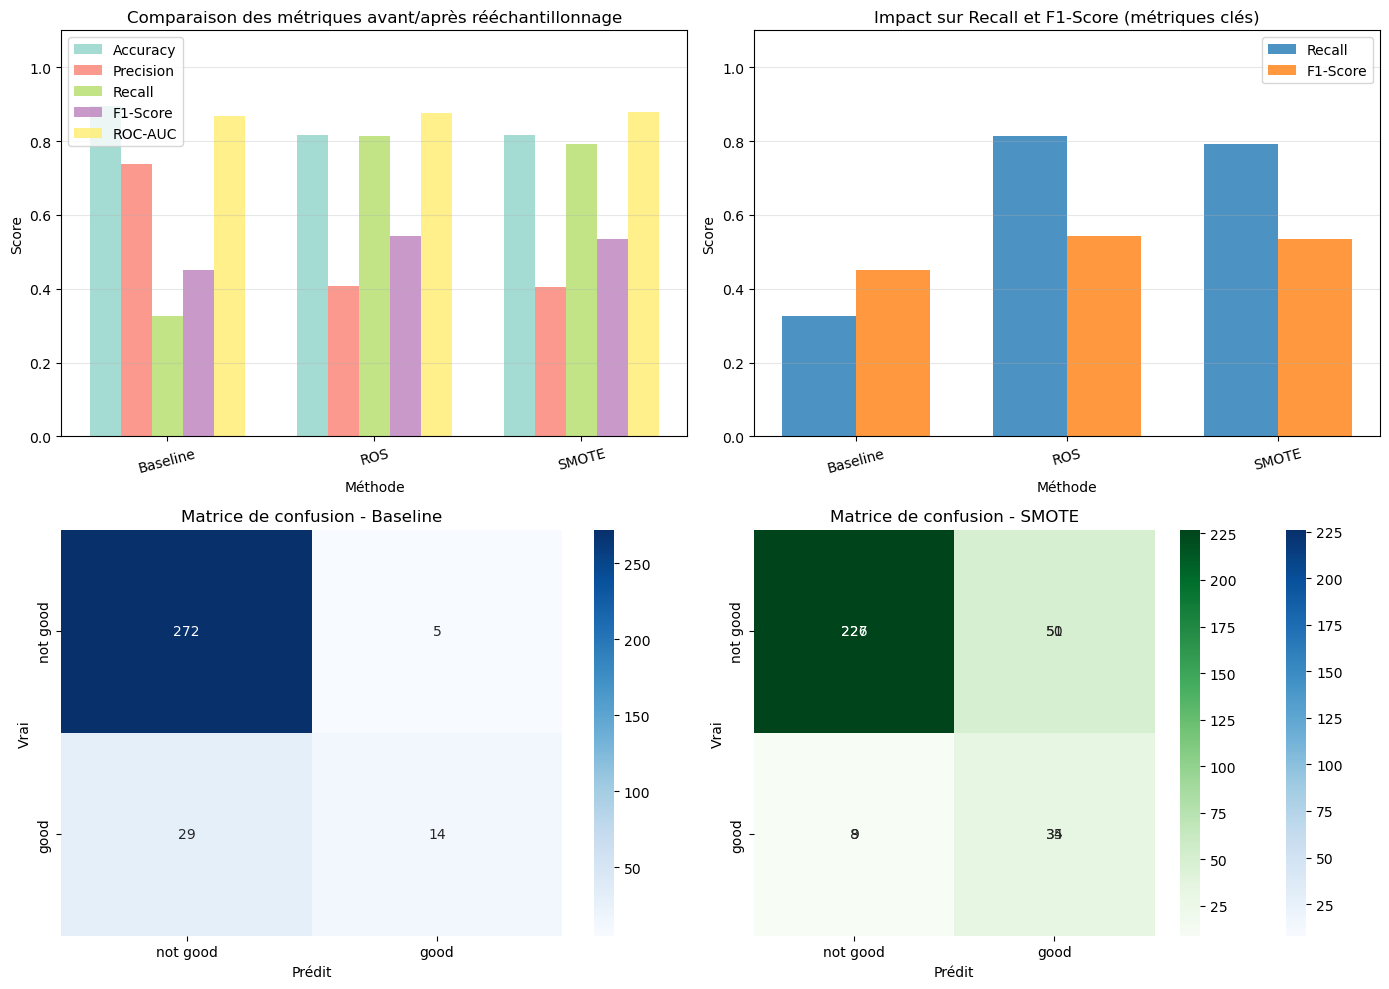


EXERCICES 1 & 2 TERMINÉS


In [ ]:
# --- 2.7. Visualisations comparatives ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (a) Comparaison des métriques
ax = axes[0, 0]
methods = results_ex2['Méthode']
x = np.arange(len(methods))
width = 0.15
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = plt.cm.Set3(np.linspace(0, 1, len(metrics_to_plot)))

for i, metric in enumerate(metrics_to_plot):
    values = results_ex2[metric]
    ax.bar(x + i*width, values, width, label=metric, color=colors[i], alpha=0.8)

ax.set_xlabel('Méthode')
ax.set_ylabel('Score')
ax.set_title('Comparaison des métriques avant/après rééchantillonnage')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(['Baseline', 'ROS', 'SMOTE'], rotation=15)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

# (b) Focus sur Recall et F1-Score
ax = axes[0, 1]
x = np.arange(len(methods))
width = 0.35
bars1 = ax.bar(x - width/2, results_ex2['Recall'], width, label='Recall', alpha=0.8)
bars2 = ax.bar(x + width/2, results_ex2['F1-Score'], width, label='F1-Score', alpha=0.8)
ax.set_xlabel('Méthode')
ax.set_ylabel('Score')
ax.set_title('Impact sur Recall et F1-Score (métriques clés)')
ax.set_xticks(x)
ax.set_xticklabels(['Baseline', 'ROS', 'SMOTE'], rotation=15)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

# (c) Matrices de confusion
cms = [('Baseline', cm_baseline), ('ROS', cm_ros), ('SMOTE', cm_smote)]
for idx, (name, cm) in enumerate(cms[:2]):
    ax = axes[1, idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['not good', 'good'], yticklabels=['not good', 'good'])
    ax.set_title(f'Matrice de confusion - {name}')
    ax.set_ylabel('Vrai')
    ax.set_xlabel('Prédit')

# SMOTE dans un subplot séparé
ax = axes[1, 1]
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Greens', ax=ax,
            xticklabels=['not good', 'good'], yticklabels=['not good', 'good'])
ax.set_title('Matrice de confusion - SMOTE')
ax.set_ylabel('Vrai')
ax.set_xlabel('Prédit')

plt.tight_layout()
plt.show()